In [1]:
# ===========================================================
# 0. IMPORTAÇÕES
# ===========================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib


In [ ]:
# ===========================================================
# 1. CARREGAR DATAFRAME E CRIAR FEATURES TEMPORAIS
# ===========================================================

# Ajuste o caminho conforme sua pasta
CAMINHO_ARQUIVO = "data/processed/df_cluster_id.parquet"

df = pd.read_parquet(CAMINHO_ARQUIVO)

print("Dimensão do df:", df.shape)
display(df.head())

# ----------------------------------------
# Garantir que year_month está em string e converter para datetime
# ----------------------------------------
df["year_month"] = df["year_month"].astype(str)
df["year_month_dt"] = pd.to_datetime(df["year_month"], format="%Y-%m")

# Extrair mês (1 a 12)
df["month"] = df["year_month_dt"].dt.month

# Criar um índice de tempo (em meses) a partir do menor ano/mês do dataset
data_min = df["year_month_dt"].min()
df["time_index"] = ((df["year_month_dt"].dt.year - data_min.year) * 12 +
                   (df["year_month_dt"].dt.month - data_min.month))

# Codificação cíclica da sazonalidade mensal
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df[["year_month", "year_month_dt", "month", "time_index", "month_sin", "month_cos"]].head()

Dimensão do df: (1219600, 9)


,year_month,item,category,department,store_code,region,sales,mean_price,year
0,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,Boston,0.0,10.9858,2013
1,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Boston,0.0,10.9858,2013
2,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Boston,0.0,10.9858,2013
3,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,0.0,10.9858,2013
4,2013-01,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,New York,0.0,10.9858,2013


,year_month,year_month_dt,month,time_index,month_sin,month_cos
0,2013-01,2013-01-01,1,0,0.5,0.866025
1,2013-01,2013-01-01,1,0,0.5,0.866025
2,2013-01,2013-01-01,1,0,0.5,0.866025
3,2013-01,2013-01-01,1,0,0.5,0.866025
4,2013-01,2013-01-01,1,0,0.5,0.866025


 - time_index captura tendência ao longo do tempo (momento da série: início x mais recente).

 - month_sin e month_cos capturam a posição do mês dentro do ciclo anual, permitindo que meses iguais em anos diferentes sejam considerados semelhantes (sazonalidade).




Shape de X_scaled: (1219600, 4)
Treinando K-Means em amostra de 50000 linhas (de 1219600).
Shape de X_cluster: (1219600, 4)
Usando amostra de 50000 linhas (de 1219600) para avaliação de k.
Avaliando k = 2...
Avaliando k = 3...
Avaliando k = 4...
Avaliando k = 5...
Avaliando k = 6...
Avaliando k = 7...
Avaliando k = 8...


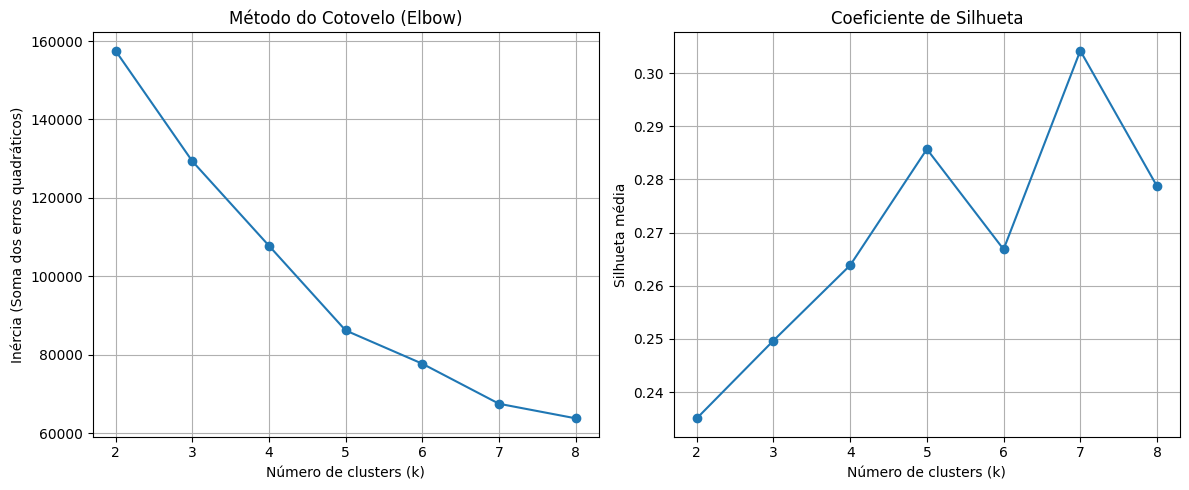

,k,inertia,silhouette
0,2,157531.850580,0.235054
1,3,129391.989363,0.249695
2,4,107827.834188,0.263859
3,5,86233.207188,0.285713
4,6,77747.318137,0.266855
5,7,67540.607141,0.304231
6,8,63827.277441,0.278740


Contagem de observações por cluster:
cluster_id
0    311624
1    338571
2     84123
3    228641
4    256641
Name: count, dtype: int64
Salvos: scaler_cluster_leve.pkl e kmeans_cluster_leve.pkl
DataFrame com cluster_id salvo em: df_com_cluster_id.csv
DataFrame com cluster_id salvo em: df_com_cluster_id.parquet


In [7]:
# ===========================================================
# CLUSTERIZAÇÃO LEVE PARA GERAR cluster_id
#    - usa apenas variáveis numéricas
#    - treina em amostra
# ===========================================================

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

# 1) Definir features numéricas para a clusterização
cluster_features = ["mean_price", "time_index", "month_sin", "month_cos"]

for col in cluster_features:
    assert col in df.columns, f"Coluna {col} não encontrada no df."

X = df[cluster_features].values

# 2) Escalonar
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X)

print("Shape de X_scaled:", X_scaled.shape)

# 3) Amostra para treinar o K-Means
n_amostra_kmeans = 50000

n_total = X_scaled.shape[0]
if n_total > n_amostra_kmeans:
    np.random.seed(42)
    idx_sample = np.random.choice(n_total, size=n_amostra_kmeans, replace=False)
    X_kmeans = X_scaled[idx_sample]
    print(f"Treinando K-Means em amostra de {n_amostra_kmeans} linhas (de {n_total}).")
else:
    X_kmeans = X_scaled
    print(f"Treinando K-Means em todas as {n_total} linhas.")

# ===========================================================
# 4. ESCOLHA DO NÚMERO DE CLUSTERS (k)
#    MÉTODOS DO COTOVELO (ELBOW) E SILHUETA
# ===========================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 4.1 Definir features da clusterização (mesmas do modelo final)
cluster_features = ["mean_price", "time_index", "month_sin", "month_cos"]

for col in cluster_features:
    assert col in df.columns, f"Coluna {col} não encontrada no df."

X_cluster = df[cluster_features].values

print("Shape de X_cluster:", X_cluster.shape)

# 4.2 Amostra para não pesar demais
n_amostra_k = 50000  # ajuste se quiser menor, ex.: 30000

n_total = X_cluster.shape[0]
if n_total > n_amostra_k:
    np.random.seed(42)
    idx_sample_k = np.random.choice(n_total, size=n_amostra_k, replace=False)
    X_sample = X_cluster[idx_sample_k]
    print(f"Usando amostra de {n_amostra_k} linhas (de {n_total}) para avaliação de k.")
else:
    X_sample = X_cluster
    print(f"Usando todas as {n_total} linhas para avaliação de k.")

# 4.3 Padronização TEMPORÁRIA (não é o scaler usado no modelo final)
scaler_temp = StandardScaler()
X_sample_scaled = scaler_temp.fit_transform(X_sample)

# 4.4 Avaliar diferentes valores de k
k_values = range(2, 9)  # por exemplo, k de 2 até 8
inertias = []
silhouettes = []

for k in k_values:
    print(f"Avaliando k = {k}...")
    kmeans_temp = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels_k = kmeans_temp.fit_predict(X_sample_scaled)

    inertia_k = kmeans_temp.inertia_
    inertias.append(inertia_k)

    sil_k = silhouette_score(X_sample_scaled, labels_k)
    silhouettes.append(sil_k)

# 4.5 Gráficos: Elbow (Inertia) e Silhouette
plt.figure(figsize=(12, 5))

# Gráfico do cotovelo (inertia)
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker="o")
plt.title("Método do Cotovelo (Elbow)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia (Soma dos erros quadráticos)")
plt.grid(True)

# Gráfico da silhueta
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes, marker="o")
plt.title("Coeficiente de Silhueta")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhueta média")
plt.grid(True)

plt.tight_layout()
plt.show()

# (Opcional) tabela com os valores
df_k_avaliacao = pd.DataFrame({
    "k": list(k_values),
    "inertia": inertias,
    "silhouette": silhouettes
})
display(df_k_avaliacao)

k_final = 5

kmeans_final = KMeans(n_clusters=k_final,random_state=42,n_init=10)

kmeans_final.fit(X_kmeans)

# 5) Predizer cluster_id para TODAS as linhas
df["cluster_id"] = kmeans_final.predict(X_scaled)

print("Contagem de observações por cluster:")
print(df["cluster_id"].value_counts().sort_index())

# 6) Salvar artefatos e df clusterizado
joblib.dump(scaler_cluster, "scaler_cluster_leve.pkl")
joblib.dump(kmeans_final, "kmeans_cluster_leve.pkl")
print("Salvos: scaler_cluster_leve.pkl e kmeans_cluster_leve.pkl")

df.to_csv("df_com_cluster_id.csv", index=False)
df.to_parquet("df_com_cluster_id.parquet", index=False)
print("DataFrame com cluster_id salvo em: df_com_cluster_id.csv")
print("DataFrame com cluster_id salvo em: df_com_cluster_id.parquet")


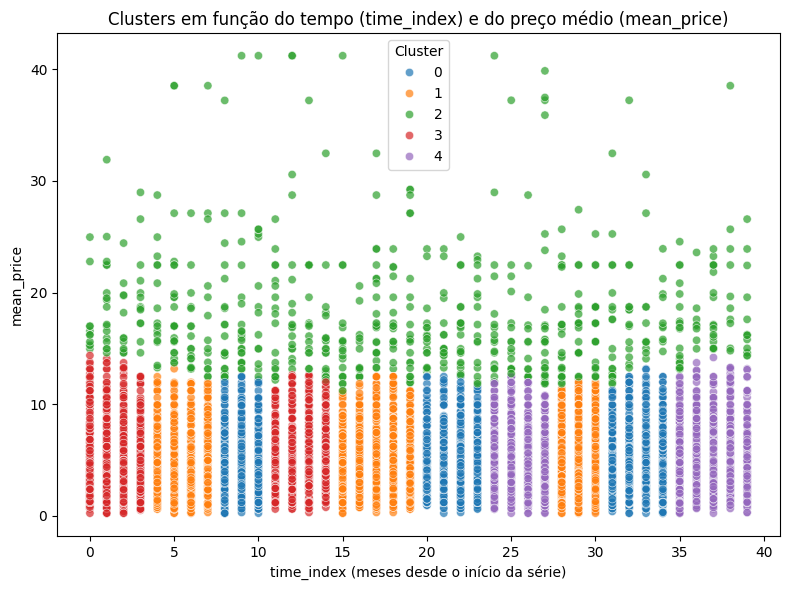

In [8]:
# ===========================================================
# 5. VISUALIZAÇÃO GRÁFICA DOS CLUSTERS
# ===========================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Amostra para não pesar o gráfico
df_sample = df.sample(n=min(10000, len(df)), random_state=42)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x="time_index",
    y="mean_price",
    hue="cluster_id",
    palette="tab10",
    alpha=0.7
)
plt.title("Clusters em função do tempo (time_index) e do preço médio (mean_price)")
plt.xlabel("time_index (meses desde o início da série)")
plt.ylabel("mean_price")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


cluster_id,0,1,2,3,4
time_index,,,,,
0,NaN,NaN,10.490391,34.254512,NaN
1,NaN,NaN,11.308511,34.280411,NaN
2,NaN,NaN,12.196742,38.004568,NaN
3,NaN,NaN,10.795163,35.559479,NaN
4,NaN,36.958226,11.219043,NaN,NaN


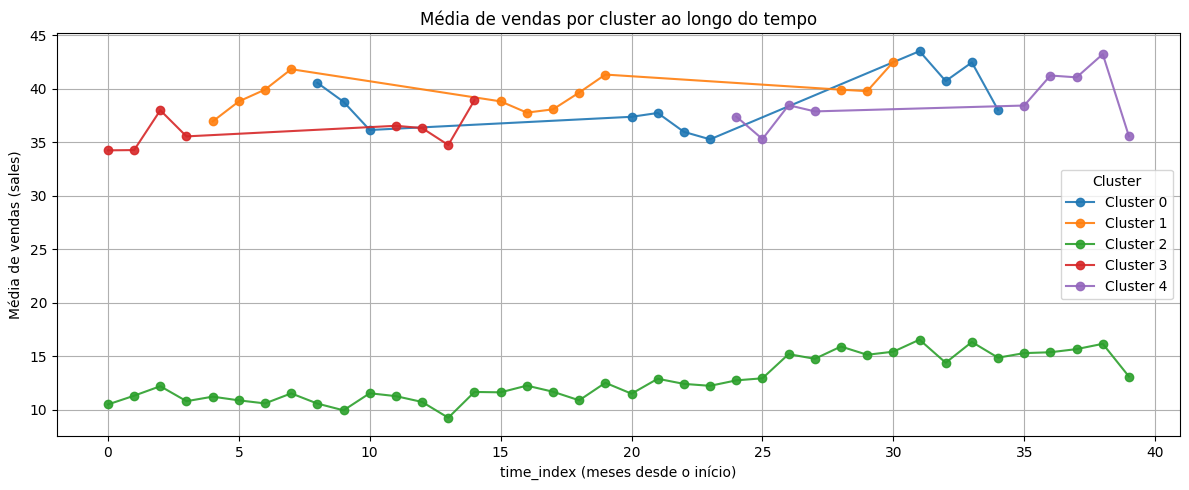

In [9]:
# ===========================================================
# 6. MÉDIA DE VENDAS POR CLUSTER AO LONGO DO TEMPO
# ===========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Agrupa: média de vendas por time_index e cluster_id
cluster_time = (
    df.groupby(["time_index", "cluster_id"])["sales"]
      .mean()
      .reset_index()
      .sort_values("time_index")
)

# 2) (Opcional) tabela em formato wide para consulta/salvar
tabela_cluster_time = cluster_time.pivot(
    index="time_index",
    columns="cluster_id",
    values="sales"
)
display(tabela_cluster_time.head())

# 3) Gráfico de linhas: média de vendas por cluster ao longo do tempo
plt.figure(figsize=(12, 5))

for c in sorted(cluster_time["cluster_id"].unique()):
    dados_c = cluster_time[cluster_time["cluster_id"] == c]
    plt.plot(
        dados_c["time_index"],
        dados_c["sales"],
        marker="o",
        linewidth=1.5,
        alpha=0.9,
        label=f"Cluster {c}"
    )

plt.title("Média de vendas por cluster ao longo do tempo")
plt.xlabel("time_index (meses desde o início)")
plt.ylabel("Média de vendas (sales)")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) (Opcional) salvar a tabela de médias em CSV
tabela_cluster_time.to_csv("media_sales_por_cluster_no_tempo.csv")


 - Análise dos clusters

A partir da clusterização realizada com base nas variáveis mean_price, time_index, month_sin e month_cos, foram identificados cinco grupos de comportamento distintos ao longo da série temporal. No gráfico de dispersão entre time_index e mean_price, observa-se que os clusters ocupam faixas diferentes de preço médio e se distribuem ao longo de todo o período analisado, indicando que o modelo conseguiu separar perfis de combinação entre nível de preço e evolução no tempo.

O Cluster 2 se destaca como o grupo de preço mais elevado, concentrando observações em faixas superiores de mean_price. No entanto, quando analisamos a média de vendas por cluster ao longo do tempo, esse grupo apresenta os menores volumes de vendas, configurando um perfil “premium de baixa demanda”. Em contraste, o Cluster 1 reúne observações com preços médios intermediários e, ao longo do tempo, apresenta as maiores médias de vendas, caracterizando um perfil de alto desempenho comercial, com bom equilíbrio entre preço e volume.

Os Clusters 0 e 4 também operam em faixas de preço intermediário, com trajetória de vendas relativamente estável e crescente ao longo dos meses. Esses grupos podem ser interpretados como segmentos consolidados, com desempenho consistente e menor variação de comportamento entre períodos. Já o Cluster 3 concentra observações em faixas de preço mais baixas, mas mantém médias de vendas próximas às dos clusters de melhor desempenho, sugerindo um perfil mais sensível a políticas de preço e promoções, porém ainda relevante em termos de volume.

De forma geral, a análise dos clusters mostra que o modelo conseguiu separar perfis de itens/lojas que combinam diferentes níveis de preço e volume ao longo do tempo. Esses grupos são úteis tanto para interpretação do comportamento histórico quanto como insumo para a etapa de predição, por meio da variável cluster_id, que incorpora ao modelo de vendas a informação sobre o “tipo” de comportamento de preço e demanda associado a cada observação.

In [11]:
# ===========================================================
# 5. SALVAR PRÉ-PROCESSADOR, MODELO DE CLUSTER E DATAFRAME
# ===========================================================

# Salvar pré-processador e modelo de clusterização (para usar depois no modelo de predição / app)
joblib.dump(scaler_cluster, "preprocess_cluster.pkl")
joblib.dump(kmeans_final, "kmeans_cluster_model.pkl")

print("Arquivos salvos: preprocess_cluster.pkl, kmeans_cluster_model.pkl")

# Salvar o df com cluster_id
OUTPUT_CSV = "df_com_cluster_id.csv"
OUTPUT_PARQUET = "df_com_cluster_id.parquet"
df.to_csv(OUTPUT_CSV, index=False)
df.to_parquet(OUTPUT_PARQUET, index=False)

print(f"DataFrame com cluster_id salvo em: {OUTPUT_CSV}")
print(f"DataFrame com cluster_id salvo em: {OUTPUT_PARQUET}")

Arquivos salvos: preprocess_cluster.pkl, kmeans_cluster_model.pkl
DataFrame com cluster_id salvo em: df_com_cluster_id.csv
DataFrame com cluster_id salvo em: df_com_cluster_id.parquet
